### Mortality and Readmission Outcomes of a Heart Failure Cohort

#### Part 4 : Forecasting

#### Data Source: Physionet: Hospitalized Patients with Heart Failure (Zhang et al., 2020)

### Outline

I.  Data Loading and Preparation

II.  Forecasting

    A.  Custom Codes
    B.  Analyses
            1.  Linear Regression for select clinical variables
            2.  Modeling for 28-day Mortality using Statsmodels OLS
            3.  Checking for other Features
            4.  Validating model using Logistic Regression
            5.  Select Visualizations
    C.  Summary of Findings

In [383]:
# HF EHR and outcome
import pandas as pd
pd.options.display.max_columns = 170
pd.options.display.max_colwidth = 100
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import statistics as stat
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [384]:
# loading de-identified data, prepared from Parts 1-3
hf3 = pd.read_csv('hf4.csv', header=0)
hf3.drop(columns = 'Unnamed: 0', axis = 1, inplace=True)

In [385]:
hf3.head()

,mort.28d,age,gender,visit.times,admission.way,HR,RR,SBP,DBP,MAP,temp,Wt,BMI,GCS,CHF,HF.type,NYHA,Killip,PVD,CVD,CKD,ARF,RespFailureII,resp.support,O2,FiO2,CTD,liver.disease,dementia,hemiplegia,lymphoma,solid.tumor,AIDS,CCI.score,LVEDD,WBC,mono.ct,mono.ratio,neut.ct,neut.ratio,lymph.ct,baso.ct,baso.ratio,eo.ct,eo.ratio,RBC,Hb,Hct,CV.RBC.DW,SD.RBC.DW,MCV,MHV,MHC,Plt,MPV,P.DW,Plt.hct,INR,APTT,TT,PT.act,PT.ratio,Ddimer,fibrinogen,CK,CK.enz,CK.enz.CK,GFR,crea,urea,uric.acid,cystatin,CO2.BC,Na,K,Cl,Ca,HBD.LDH,HBD,AST,LDH,BNP,nucleotidase,fucosidase,albumin,globulin,w.glob.ratio,GTP,ALT,DB,IB,TB,AP,bile,TP,cholesterol,LDL,HDL,triglyceride,hosp.outcome,LOS,read.28d
0,0,"(69,79]",Male,1,NonEmergency,87,19,102,64,76.666667,36.7,50,18,15,0,Both,3,3,0,0,0,0,NonTypeII,NoSupport,OxygenTherapy,33,0,0,0,0,0,0,0,2,52.0,9.43,0.80,0.085,7.05,0.746,1.51,0.05,0.006,0.02,0.002,4.09,131,0.387,15.0,50.3,94,32.0,338,102,14.0,16.6,0.142,1.39,33,17.0,60,1.37,1.19,3.84,43,9.6,0.22,58,108,12.55,685,1.32,21.6,134,5.59,101,2.28,0.630000,185,65,294,1500,3.5,20.5,38,23.8,1.6,83,81.0,6.9,11.4,18.3,61,4.9,61,3.46,1.90,0.84,2.69,Alive,11,0
1,0,"(69,79]",Female,1,NonEmergency,95,18,150,70,96.666667,36.8,51,19,15,0,Both,3,1,0,0,0,0,NonTypeII,NoSupport,OxygenTherapy,33,0,0,0,0,0,0,0,0,40.0,5.32,0.35,0.066,3.73,0.702,1.18,0.01,0.002,0.05,0.009,3.93,114,0.349,13.0,40.7,88,28.9,326,123,11.3,16.1,0.139,1.16,35,18.4,65,1.18,1.06,2.62,107,17.2,0.16,85,62,4.29,170,1.25,26.5,144,3.62,105,2.28,0.840000,170,19,203,361,2.2,21.9,40,25.4,1.6,17,21.0,5.2,13.1,18.3,69,2.4,66,3.15,1.26,1.30,0.84,Alive,8,0
2,0,"(59,69]",Male,2,NonEmergency,98,18,102,67,78.666667,36.5,70,24,15,0,Both,2,2,0,0,0,0,NonTypeII,NoSupport,OxygenTherapy,33,0,0,0,0,0,0,0,0,46.0,13.01,0.67,0.051,11.54,0.887,0.75,0.03,0.002,0.02,0.002,4.43,144,0.427,12.9,44.5,96,32.6,339,169,12.0,16.5,0.203,1.10,36,14.9,85,1.09,0.83,5.74,38,14.6,0.38,31,185,15.99,567,2.43,21.6,142,4.15,107,2.56,0.770000,105,10,137,293,2.3,12.3,33,27.7,1.2,27,9.0,4.4,7.5,11.9,76,2.4,60,3.79,2.13,0.94,1.53,Alive,5,0
3,0,"(69,79]",Male,1,Emergency,73,19,110,74,86.000000,36.0,65,22,15,0,Both,3,2,0,0,1,0,NonTypeII,NoSupport,OxygenTherapy,33,0,0,0,0,0,0,0,2,52.0,2.18,0.19,0.087,1.22,0.559,0.71,0.00,0.000,0.06,0.028,2.71,94,0.277,18.8,69.0,102,34.7,339,35,12.4,19.4,0.032,1.37,38,18.3,60,1.36,1.39,2.63,89,15.8,0.17,58,104,8.16,635,2.32,21.1,136,3.76,101,2.35,0.817057,183,9,225,1071,11.2,19.4,40,27.0,1.5,134,25.0,25.4,26.2,51.6,191,9.4,67,2.92,1.31,0.98,0.92,Alive,11,1
4,0,"(69,79]",Female,1,NonEmergency,88,19,134,62,86.000000,35.0,76,31,15,0,Both,3,2,0,0,0,0,NonTypeII,NoSupport,OxygenTherapy,33,0,0,0,0,0,0,0,0,64.0,6.14,0.53,0.086,4.28,0.697,1.27,0.01,0.002,0.05,0.008,4.20,120,0.378,14.7,47.7,90,28.6,317,104,12.6,16.4,0.131,1.19,34,16.4,74,1.19,0.57,3.50,122,13.6,0.11,60,83,6.86,432,1.35,22.8,136,3.94,104,2.42,0.920000,270,19,295,372,2.9,12.3,42,29.6,1.4,17,30.0,4.9,6.9,11.8,61,3.3,71,2.68,1.21,0.91,0.62,Alive,5,0


In [386]:
# chosen outcome measure:
# previous univariate exploration showed that the mort.28d showed the most
# availability of data on death

In [387]:
# converting to dummy variables
hf3['age'] = hf3['age'].replace({'(21,29]':25,
                                '(29,39]':35,
                                 '(39,49]':45,
                                 '(49,59]':55,
                                 '(59,69]':65,
                                 '(69,79]':75,
                                 '(79,89]':85,
                                 '(89,110]':95})

hf3['gender'] = hf3['gender'].replace({'Male':1,'Female':0})

hf3['admission.way'] = hf3['admission.way'].replace({'Emergency':1,'NonEmergency':0})

hf3['HF.type'] = hf3['HF.type'].replace({'Left':1,'Right':2,'Both':3})

hf3['RespFailureII'] = hf3['RespFailureII'].replace({'TypeII':1,'NonTypeII':0})

hf3['resp.support'] = hf3['resp.support'].replace({'IMV':1,'NIMV':2,'NoSupport':0})

hf3['O2'] = hf3['O2'].replace({'OxygenTherapy':1,'AmbientAir':0})

hf3['hosp.outcome'] = hf3['hosp.outcome'].replace({'Dead':1,'Alive':0,'DischargeAgainstOrder':2})

#### II. A.  Forecasting: Custom Codes

For Algorithms

In [388]:
def linear_regression(varx, vary, labelx, labely):
    plt.scatter(hf3[varx], hf3[vary])
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.suptitle(t = 'Linear Regression for '+ varx + ' & ' + vary)
    X= hf3[varx].values.reshape(-1,1)
    Y = hf3[vary]
    model = sklearn.linear_model.LinearRegression().fit(X,Y)
    print('model coefficient = ', model.coef_)
    print('model intercept = ', model.intercept_)
    lin_pred = model.predict(X)
    plt.plot(X, model.predict(X), 'r-');

In [389]:
def rsquared(var):
    X = hf3[ ['GCS', 'Killip','ARF', var]]
    y = hf3['mort.28d']
    model = sm.OLS(y,X).fit()
    print(var, (model.rsquared).round(4))

For Visualization

In [390]:
def multivariable_bubbleb(varx, vary, varsize, title):
    plt.figure(figsize = (12,7))
    sns.scatterplot(data = hf3, x = varx, y = vary, hue = 'mort.28d',
                   size = varsize, sizes = (50,250), legend = 'brief', alpha = 1)
    plt.title('28-Day Mortality in the Background of %s'%title)

In [391]:
def bivariate_table_pieplots5b(var, title):
    print('28-Day Mortality Among', title, 'Groups')
    val = hf3.groupby('mort.28d')[var].value_counts().sort_index()
    val.unstack().plot.pie(subplots = True, figsize = (5,4.5), 
                           fontsize = 14, cmap = 'RdBu',
                           shadow=True, 
                           legend = False, labels = None, 
                           autopct = '%.1f', pctdistance =0.3,
                           textprops = {'color':"w"}, 
                           explode = (0.2,0), startangle=90)
    plt.legend(labels = ('Survival','Mortality'), bbox_to_anchor = (1,1))

In [392]:
def bivariate_table_pieplotsb(var, title):
    print('28-Day Mortality Among', title, 'Groups')
    val = hf3.groupby('mort.28d')[var].value_counts().sort_index()
    val.unstack().plot.pie(subplots = True, figsize = (20,10), 
                           fontsize = 14, cmap= 'Spectral', 
                           shadow=True, layout=(5,2),
                           legend = False, labels = None, 
                           autopct = '%.1f', pctdistance =0.3,
                           textprops = {'color':"w"}, 
                           explode = (0.15,0), startangle=90)
    plt.subplots_adjust(wspace=-0.75, hspace= 0,bottom =0)
    plt.legend(labels = ('Survival','Mortality'), bbox_to_anchor = (1,1))

In [393]:
def bivariate_table_pieplots2b(var, title):
    print('28-Day Mortality Among', title, 'Groups')
    val = hf3.groupby('mort.28d')[var].value_counts().sort_index()
    val.unstack().plot.pie(subplots = True, figsize = (6,6), 
                           fontsize = 14, cmap = 'copper',
                           shadow=True, layout=(2,2),
                           legend = False, labels = None, 
                           autopct = '%.1f', pctdistance =0.3,
                           textprops = {'color':"w"}, 
                           explode = (0.15,0), startangle=90)
    plt.subplots_adjust(wspace=0.3, hspace= 0,bottom =0)
    plt.legend(labels = ('Survival','Mortality'), bbox_to_anchor = (1,1))

#### II. B.  Forecasting

####   1.  Linear Regression

Analyzing for Quantitative Relationship between Clinical Variables

model coefficient =  [-0.19479329]
model intercept =  105.08102883356032


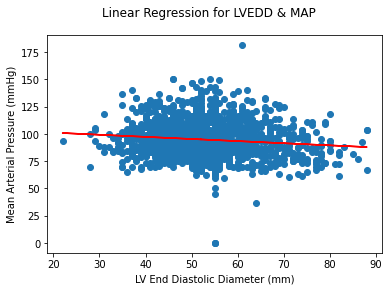

In [394]:
linear_regression('LVEDD','MAP','LV End Diastolic Diameter (mm)','Mean Arterial Pressure (mmHg)')

Findings:
- There is a gradual decrease in MAP with increasing LVEDD, with a coefficient of -0.2
- There were minimal outliers. The outermost outliers probably cancels each other out.

model coefficient =  [0.06781188]
model intercept =  81.63316656371553


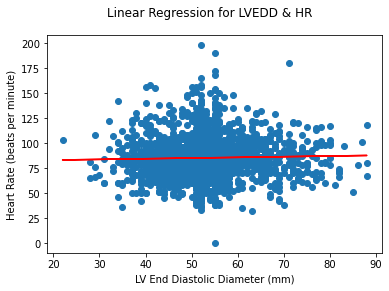

In [395]:
linear_regression('LVEDD','HR','LV End Diastolic Diameter (mm)','Heart Rate (beats per minute)')

Findings:
- There is a very weak correlation between HR and LVEDD, with slight increase in HR for increasing LVEDD

model coefficient =  [52.8060877]
model intercept =  -1533.7800043023349


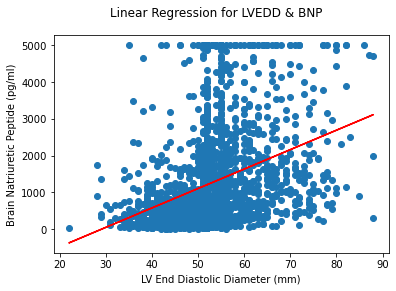

In [396]:
linear_regression('LVEDD','BNP','LV End Diastolic Diameter (mm)','Brain Natriuretic Peptide (pg/ml)')

Findings:
- There is a strong correlation between BNP and LVEDD
- BNP increases at 52 pg/ml for every mm width increase in LVEDD

model coefficient =  [0.00669083]
model intercept =  1.9879141465105676


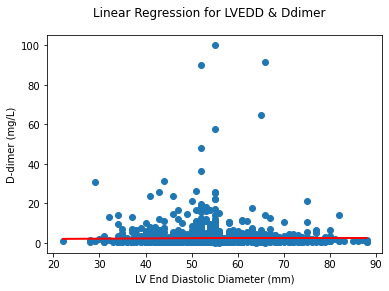

In [397]:
linear_regression('LVEDD','Ddimer','LV End Diastolic Diameter (mm)','D-dimer (mg/L)')

Findings:
- There is no correlation between LVEDD and D-dimer values

#### II. B.  Forecasting
####           2.  Modeling for 28-day Mortality rate using Statsmodels OLS

In [398]:
# run 1
X = hf3[ ['age','gender','visit.times',
 'admission.way', 'HR', 'RR', 'SBP', 
 'DBP', 'MAP',  'temp',  'Wt', 
 'BMI','GCS', 'CHF', 'HF.type', 'NYHA','Killip','PVD',
 'CVD','CKD', 'ARF', 'RespFailureII', 'resp.support', 'O2', 'FiO2',
 'CTD', 'liver.disease', 'dementia', 'hemiplegia','lymphoma', 'solid.tumor',
 'AIDS', 'CCI.score', 'LVEDD',  'WBC', 'mono.ct',
 'mono.ratio','neut.ct','neut.ratio', 'lymph.ct', 'baso.ct','baso.ratio',
 'eo.ct','eo.ratio','RBC', 'Hb',  'Hct', 'CV.RBC.DW', 'SD.RBC.DW',
 'MCV', 'MHV', 'MHC', 'Plt',  'MPV', 'P.DW', 'Plt.hct','INR',
 'APTT', 'TT', 'PT.act', 'PT.ratio', 'Ddimer',  'fibrinogen',
 'CK',  'CK.enz', 'CK.enz.CK', 'GFR',  'crea', 
 'urea',  'uric.acid', 'cystatin', 'CO2.BC', 'Na', 
 'K', 'Cl', 'Ca', 'HBD.LDH', 'HBD', 'AST', 'LDH',  'BNP', 
 'nucleotidase', 'fucosidase', 'albumin', 'globulin', 'w.glob.ratio', 'GTP',
 'ALT', 'DB', 'IB', 'TB', 'AP', 'bile', 'TP', 'cholesterol', 'LDL', 'HDL',
 'triglyceride']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()
# removing variables hosp.outcome, LOS, read.28d due to overlapping outcomes that may lead to misinterpretation of results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.351
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              10.67
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                   5.26e-120
Time:                        12:49:18   Log-Likelihood:                          1595.2
No. Observations:                2008   AIC:                                     -2996.
Df Residuals:                    1911   BIC:                                     -2453.
Df Model:                          97                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
age           -1.368e-05      0.000     -0.047      0.963      -0.001       0.001
gender           -0.0063      0.007     -0.888      0.374      -0.020       0.008
visit.times      -0.0013      0.007     -0.175      0.861      -0.016       0.013
admission.way    -0.0008      0.005     -0.153      0.878      -0.011       0.010
HR             2.326e-05      0.000      0.173      0.863      -0.000       0.000
RR                0.0006      0.002      0.332      0.740      -0.003       0.004
SBP           -6.418e-05      0.000     -0.381      0.703      -0.000       0.000
DBP            4.525e-05      0.000      0.232      0.817      -0.000       0.000
MAP            8.773e-06   9.12e-05      0.096      0.923      -0.000       0.000
temp              0.0012      0.005      0.220      0.826      -0.009       0.012
Wt                0.0006      0.001      1.148      0.251      -0.000       0.002
BMI              -0.0007      0.001     -0.512      0.609      -0.004       0.002
GCS              -0.0373      0.003    -13.836      0.000      -0.043      -0.032
CHF              -0.0119      0.012     -1.013      0.311      -0.035       0.011
HF.type          -0.0014      0.003     -0.435      0.664      -0.007       0.005
NYHA              0.0065      0.004      1.581      0.114      -0.002       0.015
Killip            0.0180      0.004      4.886      0.000       0.011       0.025
PVD               0.0161      0.013      1.257      0.209      -0.009       0.041
CVD               0.0168      0.011      1.496      0.135      -0.005       0.039
CKD               0.0170      0.009      1.956      0.051   -4.27e-05       0.034
ARF               0.1971      0.044      4.451      0.000       0.110       0.284
RespFailureII     0.0167      0.012      1.433      0.152      -0.006       0.040
resp.support     -0.0825      0.015     -5.638      0.000      -0.111      -0.054
O2               -0.0474      0.016     -3.055      0.002      -0.078      -0.017
FiO2              0.0037      0.001      4.158      0.000       0.002       0.005
CTD              -0.1160      0.058     -1.993      0.046      -0.230      -0.002
liver.disease     0.0285      0.014      2.002      0.045       0.001       0.056
dementia         -0.0002      0.012     -0.015      0.988      -0.023       0.023
hemiplegia       -0.0096      0.035     -0.275      0.783      -0.078       0.059
lymphoma         -0.0322      0.114     -0.282      0.778      -0.257       0.192
solid.tumor      -0.0251      0.019     -1.288      0.198      -0.063       0.013
AIDS             -0.0937      0.059     -1.601      0.110      -0.208       0.021
CCI.score        -0.0068      0.004     -1.538      0.124      -0.016       0.002
LVEDD            -0.0002      0.

In [399]:
# run 2
# removal of p >0.05
X = hf3[ ['GCS', 'Killip', 'ARF',  'resp.support', 'O2', 'FiO2',
 'CTD', 'liver.disease', 'TT', 'PT.act',   'fibrinogen',
 'CK',  'CK.enz', 'CK.enz.CK',   'crea', 'urea', 
'HBD.LDH',  'AST', 'DB', 'IB', 'TB']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.265
Model:                            OLS   Adj. R-squared (uncentered):              0.257
Method:                 Least Squares   F-statistic:                              34.08
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                   1.69e-116
Time:                        12:49:18   Log-Likelihood:                          1469.6
No. Observations:                2008   AIC:                                     -2897.
Df Residuals:                    1987   BIC:                                     -2780.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
GCS              -0.0233      0.002    -14.033      0.000      -0.027      -0.020
Killip            0.0232      0.004      6.549      0.000       0.016       0.030
ARF               0.1999      0.045      4.459      0.000       0.112       0.288
resp.support     -0.0721      0.015     -4.965      0.000      -0.101      -0.044
O2               -0.0638      0.015     -4.212      0.000      -0.094      -0.034
FiO2              0.0062      0.001      8.321      0.000       0.005       0.008
CTD              -0.1017      0.059     -1.728      0.084      -0.217       0.014
liver.disease     0.0261      0.014      1.896      0.058      -0.001       0.053
TT                0.0019      0.000      4.152      0.000       0.001       0.003
PT.act           -0.0001      0.000     -0.844      0.399      -0.000       0.000
fibrinogen        0.0090      0.003      3.406      0.001       0.004       0.014
CK            -5.223e-05   1.57e-05     -3.330      0.001    -8.3e-05   -2.15e-05
CK.enz            0.0015      0.000      6.462      0.000       0.001       0.002
CK.enz.CK        -0.0883      0.023     -3.771      0.000      -0.134      -0.042
crea              0.0001    4.7e-05      2.809      0.005    3.99e-05       0.000
urea              0.0016      0.001      2.427      0.015       0.000       0.003
HBD.LDH           0.1008      0.029      3.472      0.001       0.044       0.158
AST             8.18e-05   1.53e-05      5.341      0.000    5.18e-05       0.000
DB                0.0194      0.006      3.055      0.002       0.007       0.032
IB                0.0196      0.006      3.117      0.002       0.007       0.032
TB               -0.0195      0.006     -3.095      0.002      -0.032      -0.007
==============================================================================
Omnibus:                     2168.675   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152975.333
Skew:                           5.403   Prob(JB):                         0.00
Kurtosis:                      44.372   Cond. No.                     7.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [400]:
# run 3
# further removal of p >0.05 
X = hf3[ ['GCS', 'Killip','ARF',  'resp.support', 'O2', 'FiO2',
 'TT',   'fibrinogen', 'CK',  'CK.enz', 'CK.enz.CK',   'crea', 
 'urea', 'HBD.LDH',  'AST', 'DB', 'IB', 'TB']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.262
Model:                            OLS   Adj. R-squared (uncentered):              0.255
Method:                 Least Squares   F-statistic:                              39.27
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                   2.54e-117
Time:                        12:49:18   Log-Likelihood:                          1465.9
No. Observations:                2008   AIC:                                     -2896.
Df Residuals:                    1990   BIC:                                     -2795.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
GCS             -0.0234      0.002    -14.643      0.000      -0.027      -0.020
Killip           0.0230      0.004      6.465      0.000       0.016       0.030
ARF              0.2019      0.045      4.503      0.000       0.114       0.290
resp.support    -0.0730      0.015     -5.020      0.000      -0.101      -0.044
O2              -0.0625      0.015     -4.126      0.000      -0.092      -0.033
FiO2             0.0060      0.001      8.227      0.000       0.005       0.007
TT               0.0019      0.000      4.171      0.000       0.001       0.003
fibrinogen       0.0087      0.003      3.287      0.001       0.004       0.014
CK           -5.155e-05   1.57e-05     -3.283      0.001   -8.23e-05   -2.08e-05
CK.enz           0.0015      0.000      6.419      0.000       0.001       0.002
CK.enz.CK       -0.0884      0.023     -3.773      0.000      -0.134      -0.042
crea             0.0001   4.68e-05      2.670      0.008    3.32e-05       0.000
urea             0.0018      0.001      2.678      0.007       0.000       0.003
HBD.LDH          0.0965      0.029      3.347      0.001       0.040       0.153
AST           8.962e-05   1.49e-05      6.009      0.000    6.04e-05       0.000
DB               0.0200      0.006      3.139      0.002       0.007       0.032
IB               0.0201      0.006      3.187      0.001       0.008       0.032
TB              -0.0199      0.006     -3.160      0.002      -0.032      -0.008
==============================================================================
Omnibus:                     2174.150   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           154598.712
Skew:                           5.423   Prob(JB):                         0.00
Kurtosis:                      44.595   Cond. No.                     5.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [401]:
# run 4
# p <= 0.05
# removal of coef < |0.01|
X = hf3[ ['GCS', 'Killip', 'ARF',  'resp.support', 'O2', 'CK.enz.CK',   
    'HBD.LDH',   'DB', 'IB', 'TB']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.134
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              30.84
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    7.38e-56
Time:                        12:49:18   Log-Likelihood:                          1304.8
No. Observations:                2008   AIC:                                     -2590.
Df Residuals:                    1998   BIC:                                     -2534.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
GCS             -0.0162      0.002     -9.928      0.000      -0.019      -0.013
Killip           0.0375      0.004     10.082      0.000       0.030       0.045
ARF              0.2542      0.048      5.290      0.000       0.160       0.348
resp.support     0.0132      0.014      0.956      0.339      -0.014       0.040
O2               0.0382      0.012      3.108      0.002       0.014       0.062
CK.enz.CK       -0.0049      0.020     -0.245      0.806      -0.044       0.034
HBD.LDH          0.1647      0.027      6.014      0.000       0.111       0.218
DB               0.0260      0.007      3.793      0.000       0.013       0.039
IB               0.0245      0.007      3.622      0.000       0.011       0.038
TB              -0.0247      0.007     -3.638      0.000      -0.038      -0.011
==============================================================================
Omnibus:                     2322.597   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           160093.710
Skew:                           6.133   Prob(JB):                         0.00
Kurtosis:                      44.988   Cond. No.                         627.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [402]:
# run 5
# removal of p > 0.05 
X = hf3[ ['GCS', 'Killip', 'ARF', 'O2',  'HBD.LDH',   
  'DB', 'IB', 'TB']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.130
Method:                 Least Squares   F-statistic:                              38.45
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    3.03e-57
Time:                        12:49:18   Log-Likelihood:                          1304.3
No. Observations:                2008   AIC:                                     -2593.
Df Residuals:                    2000   BIC:                                     -2548.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GCS           -0.0166      0.002    -10.465      0.000      -0.020      -0.013
Killip         0.0381      0.004     10.396      0.000       0.031       0.045
ARF            0.2536      0.048      5.279      0.000       0.159       0.348
O2             0.0391      0.012      3.191      0.001       0.015       0.063
HBD.LDH        0.1682      0.027      6.219      0.000       0.115       0.221
DB             0.0261      0.007      3.824      0.000       0.013       0.040
IB             0.0247      0.007      3.650      0.000       0.011       0.038
TB            -0.0249      0.007     -3.667      0.000      -0.038      -0.012
==============================================================================
Omnibus:                     2324.408   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           160375.196
Skew:                           6.142   Prob(JB):                         0.00
Kurtosis:                      45.023   Cond. No.                         627.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [403]:
# run 6
# p <= 0.05
# coef > 0.01
# retain variables with highest t
X = hf3[ ['GCS',  'Killip','ARF', 'HBD.LDH']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.117
Model:                            OLS   Adj. R-squared (uncentered):              0.116
Method:                 Least Squares   F-statistic:                              66.67
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    5.11e-53
Time:                        12:49:18   Log-Likelihood:                          1286.2
No. Observations:                2008   AIC:                                     -2564.
Df Residuals:                    2004   BIC:                                     -2542.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GCS           -0.0143      0.001     -9.575      0.000      -0.017      -0.011
Killip         0.0423      0.004     11.878      0.000       0.035       0.049
ARF            0.2465      0.048      5.095      0.000       0.152       0.341
HBD.LDH        0.1746      0.027      6.490      0.000       0.122       0.227
==============================================================================
Omnibus:                     2351.615   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           166366.312
Skew:                           6.262   Prob(JB):                         0.00
Kurtosis:                      45.797   Cond. No.                         255.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [404]:
# run 6
# p <= 0.05
# coef > 0.01
# retain variables with highest t
X = hf3[ ['GCS',  'Killip','ARF', 'HBD.LDH']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.117
Model:                            OLS   Adj. R-squared (uncentered):              0.116
Method:                 Least Squares   F-statistic:                              66.67
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    5.11e-53
Time:                        12:49:18   Log-Likelihood:                          1286.2
No. Observations:                2008   AIC:                                     -2564.
Df Residuals:                    2004   BIC:                                     -2542.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GCS           -0.0143      0.001     -9.575      0.000      -0.017      -0.011
Killip         0.0423      0.004     11.878      0.000       0.035       0.049
ARF            0.2465      0.048      5.095      0.000       0.152       0.341
HBD.LDH        0.1746      0.027      6.490      0.000       0.122       0.227
==============================================================================
Omnibus:                     2351.615   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           166366.312
Skew:                           6.262   Prob(JB):                         0.00
Kurtosis:                      45.797   Cond. No.                         255.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Findings:
- Four variables could model the 28-day mortality: GCS, Killip score, presence of ARF on admission, and the HBD.LDH level.

In [405]:
# run 7
# p <= 0.05
# coef > 0.01
# trim down to 3 variables
X = hf3[ ['GCS', 'Killip','ARF']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.099
Model:                            OLS   Adj. R-squared (uncentered):              0.098
Method:                 Least Squares   F-statistic:                              73.35
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    5.18e-45
Time:                        12:49:18   Log-Likelihood:                          1265.3
No. Observations:                2008   AIC:                                     -2525.
Df Residuals:                    2005   BIC:                                     -2508.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GCS           -0.0052      0.001    -10.142      0.000      -0.006      -0.004
Killip         0.0457      0.004     12.838      0.000       0.039       0.053
ARF            0.2457      0.049      5.028      0.000       0.150       0.342
==============================================================================
Omnibus:                     2356.546   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162791.779
Skew:                           6.299   Prob(JB):                         0.00
Kurtosis:                      45.273   Cond. No.                         255.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Findings:
- Further trimming down to 3 variables (GCS, Killip, ARF) significantly reduces the R2
- Address possible improvement using next step

#### II. B.  Forecasting
####           3.  Checking for other Relevant Features

Using Feature Importance tool from Random Forest Classifier

In [406]:
X = hf3[ ['age','gender','visit.times',
 'admission.way', 'HR', 'RR', 'SBP', 
 'DBP', 'MAP',  'temp',  'Wt', 
 'BMI','GCS', 'CHF', 'HF.type', 'NYHA','Killip','PVD',
 'CVD','CKD', 'ARF', 'RespFailureII', 'resp.support', 'O2', 'FiO2',
 'CTD', 'liver.disease', 'dementia', 'hemiplegia','lymphoma', 'solid.tumor',
 'AIDS', 'CCI.score', 'LVEDD',  'WBC', 'mono.ct',
 'mono.ratio','neut.ct','neut.ratio', 'lymph.ct', 'baso.ct','baso.ratio',
 'eo.ct','eo.ratio','RBC', 'Hb',  'Hct', 'CV.RBC.DW', 'SD.RBC.DW',
 'MCV', 'MHV', 'MHC', 'Plt',  'MPV', 'P.DW', 'Plt.hct','INR',
 'APTT', 'TT', 'PT.act', 'PT.ratio', 'Ddimer',  'fibrinogen',
 'CK',  'CK.enz', 'CK.enz.CK', 'GFR',  'crea', 
 'urea',  'uric.acid', 'cystatin', 'CO2.BC', 'Na', 
 'K', 'Cl', 'Ca', 'HBD.LDH', 'HBD', 'AST', 'LDH',  'BNP', 
 'nucleotidase', 'fucosidase', 'albumin', 'globulin', 'w.glob.ratio', 'GTP',
 'ALT', 'DB', 'IB', 'TB', 'AP', 'bile', 'TP', 'cholesterol', 'LDL', 'HDL',
 'triglyceride' ,'read.28d']]
y = hf3['mort.28d']

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
MinMaxScaler().fit(X_train)
model = RandomForestClassifier(n_estimators = 100)
fitted_model = model.fit(X_train, y_train)
pd.DataFrame(model.feature_importances_, index = X_train.columns, columns= ['Feature Importance']).sort_values('Feature Importance', ascending=False).head(4)

,Feature Importance
GCS,0.042224
AST,0.036149
FiO2,0.035834
urea,0.035105


Findings:
- Other possible relevant features include AST, FiO2, ALT, K, urea

In [408]:
def rsquared(var):
    X = hf3[ ['GCS', 'Killip','ARF', var]]
    y = hf3['mort.28d']
    model = sm.OLS(y,X).fit()
    print(var, (model.rsquared).round(4))

In [409]:
variables = ['HBD.LDH','AST','FiO2','ALT','K','urea']
for variable in variables:
    rsquared(variable)

HBD.LDH 0.1174
AST 0.1298
FiO2 0.1611
ALT 0.1674
K 0.1416
urea 0.137


Findings:
- It was shown above that the first three relevant variables of GCS, Killip and ARF yields a low Rsquared of 0.099
- Adding a fourth variable, ALT, improves the Rsquared to 0.167

In [413]:
X = hf3[ ['GCS', 'Killip','ARF', 'ALT','FiO2']]
y = hf3['mort.28d']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mort.28d   R-squared (uncentered):                   0.227
Model:                            OLS   Adj. R-squared (uncentered):              0.225
Method:                 Least Squares   F-statistic:                              117.5
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                   3.26e-109
Time:                        12:50:59   Log-Likelihood:                          1419.0
No. Observations:                2008   AIC:                                     -2828.
Df Residuals:                    2003   BIC:                                     -2800.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GCS           -0.0151      0.001    -16.184      0.000      -0.017      -0.013
Killip         0.0245      0.004      6.809      0.000       0.017       0.032
ARF            0.2571      0.045      5.677      0.000       0.168       0.346
ALT            0.0001   9.62e-06     13.050      0.000       0.000       0.000
FiO2           0.0056      0.000     12.414      0.000       0.005       0.007
==============================================================================
Omnibus:                     2281.172   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175782.117
Skew:                           5.877   Prob(JB):                         0.00
Kurtosis:                      47.304   Cond. No.                     4.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Findings:
- A combination of the 5 variables of GCS, Killip, ARF, ALT and FiO2 yields a model with an Rsquared of 0.23, with a p <0.05

#### II. B.  Forecasting
####           4.  Validating model using Logistic Regression

In [414]:
# Using most variables
# Utilized scaling and train-test split
X = hf3[ ['age','gender','visit.times',
 'admission.way', 'HR', 'RR', 'SBP', 
 'DBP', 'MAP',  'temp',  'Wt', 
 'BMI','GCS', 'CHF', 'HF.type', 'NYHA','Killip','PVD',
 'CVD','CKD', 'ARF', 'RespFailureII', 'resp.support', 'O2', 'FiO2',
 'CTD', 'liver.disease', 'dementia', 'hemiplegia','lymphoma', 'solid.tumor',
 'AIDS', 'CCI.score', 'LVEDD',  'WBC', 'mono.ct',
 'mono.ratio','neut.ct','neut.ratio', 'lymph.ct', 'baso.ct','baso.ratio',
 'eo.ct','eo.ratio','RBC', 'Hb',  'Hct', 'CV.RBC.DW', 'SD.RBC.DW',
 'MCV', 'MHV', 'MHC', 'Plt',  'MPV', 'P.DW', 'Plt.hct','INR',
 'APTT', 'TT', 'PT.act', 'PT.ratio', 'Ddimer',  'fibrinogen',
 'CK',  'CK.enz', 'CK.enz.CK', 'GFR',  'crea', 
 'urea',  'uric.acid', 'cystatin', 'CO2.BC', 'Na', 
 'K', 'Cl', 'Ca', 'HBD.LDH', 'HBD', 'AST', 'LDH',  'BNP', 
 'nucleotidase', 'fucosidase', 'albumin', 'globulin', 'w.glob.ratio', 'GTP',
 'ALT', 'DB', 'IB', 'TB', 'AP', 'bile', 'TP', 'cholesterol', 'LDL', 'HDL',
 'triglyceride']]
y = hf3['mort.28d']

scores = 0
list = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    fitted_model = LogisticRegression().fit(X_train_sc, y_train)
    y_pred = fitted_model.predict(X_test_sc)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    scores += accuracy
    list.append(accuracy)
average = (scores / 10).round(2)
print('Logistic Regression List of Accuracy scores\n', list)
print('\nAverage Accuracy Score=', average)

Logistic Regression List of Accuracy scores
 [0.9850746268656716, 0.9776119402985075, 0.9875621890547264, 0.9875621890547264, 0.9875621890547264, 0.9825870646766169, 0.9825870646766169, 0.9850746268656716, 0.9875621890547264, 0.9850746268656716]

Average Accuracy Score= 0.98


In [415]:
# Using variables identified in the OLS model
X = hf3[ ['GCS', 'Killip','ARF', 'ALT','FiO2']]
y = hf3['mort.28d']

scores = 0
list = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    fitted_model = LogisticRegression().fit(X_train_sc, y_train)
    y_pred = fitted_model.predict(X_test_sc)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    scores += accuracy
    list.append(accuracy)
average = (scores / 10).round(2)
print('Logistic Regression List of Accuracy scores\n', list)
print('\nAverage Accuracy Score=', average)

Logistic Regression List of Accuracy scores
 [0.9875621890547264, 0.9850746268656716, 0.9925373134328358, 0.9825870646766169, 0.9875621890547264, 0.9751243781094527, 0.9800995024875622, 0.9850746268656716, 0.9800995024875622, 0.9875621890547264]

Average Accuracy Score= 0.98


Findings:
- The variables selected in the OLS model yielded a 99% accuracy score in the Logistic Regression train/test model

#### II. B.  Forecasting
####           5.  Select Visualizations

Visualizations on Variables identified that could be used to interpret model result

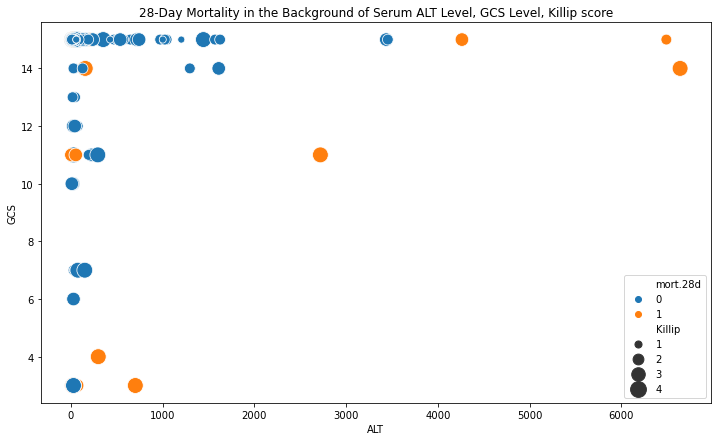

In [416]:
multivariable_bubbleb('ALT','GCS','Killip','Serum ALT Level, GCS Level, Killip score')

Findings:
- Elaborates on the model:
    - Low GCS could be predictive for mortality
    - High Killip score could be predictive for mortality
    - Elevated serum ALT could be predictive for mortality

28-Day Mortality Among Acute Renal Failure Groups


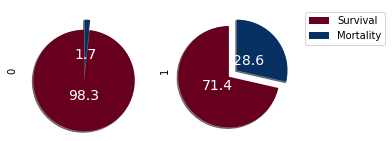

In [417]:
bivariate_table_pieplots5b('ARF','Acute Renal Failure')

Findings:
- Displays the higher preponderance of mortality in patients with ARF on admission

28-Day Mortality Among GCS Groups


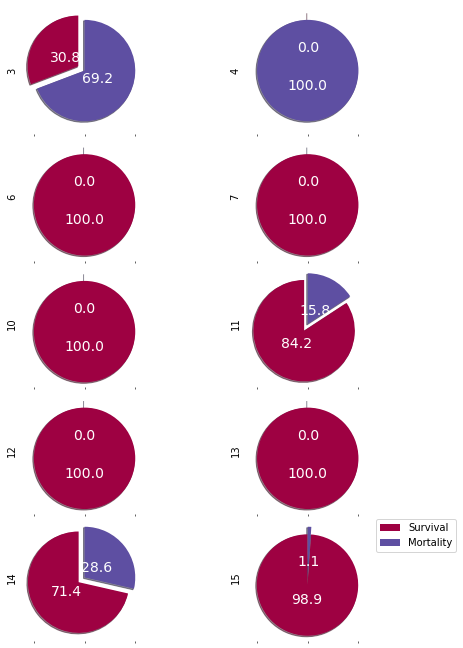

In [418]:
bivariate_table_pieplotsb('GCS','GCS')

Findings:
- Reiterates the higher mortality associated with low GCS

28-Day Mortality Among Killip score Groups


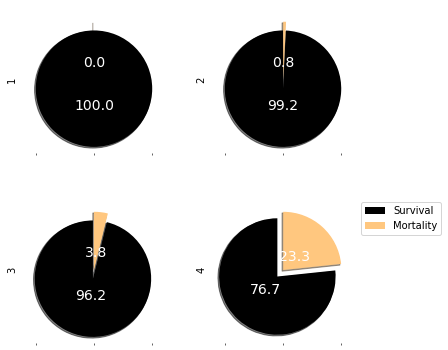

In [419]:
bivariate_table_pieplots2b('Killip','Killip score')

Findings:
- Reiterates the increased incidence of mortality for high Killip score, especially Killip 4

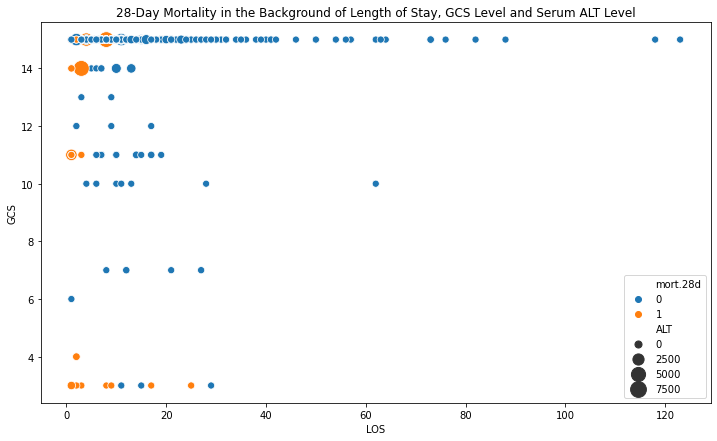

In [421]:
multivariable_bubbleb('LOS','GCS','ALT','Length of Stay, GCS Level and Serum ALT Level')

Findings:
- Reiterates the occurence of mortality with low GCS scores and elevated ALT levels, more commonly manifesting early in the first week of admission

28-Day Mortality Among FiO2 Groups


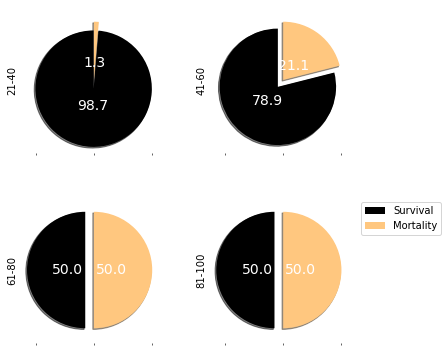

In [422]:
# rebinning FiO2 for ML visualization
var= hf3['FiO2']
labels = ['21-40', '41-60','61-80','81-100']
bins = [21, 40, 60, 80, 100]
hf3['FiO2_group']= pd.cut(hf3['FiO2'], bins = bins, labels = labels, include_lowest=True)
bivariate_table_pieplots2b('FiO2_group','FiO2')

Findings:
- Supports the model finding of increasing mortality incidence with increasing FiO2 requirements

#### II. C. Summary of Findings:  Forecasting

- With increasing LVEDD, there is:
    - a corresponding increase in BNP levels
    - a mild increase in MAP and HR

- There is no correlation between LVEDD and D-dimer values

- 28-day mortality can be modelled (p <0.5, Rsquared 0.23, 99% accuracy) using the following variables on admission:
    - GCS
    - Killip score
    - ARF
    - GOT
    - FiO2 requirement

- There was a high incidence of mortality during the first week of admission.  Duration of hospital stay was not seemed a suitable variable for modelling.
